The originial dataset is from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview. <br> I built models to predict if the image is a cat or a dog using three techniques: ResNet, VGG16 and VGG19.

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc, confusion_matrix, plot_confusion_matrix,classification_report


In [2]:
from tensorflow import keras 
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense,Input, Convolution2D, MaxPooling2D,Conv2D, Dropout, Flatten,Activation, BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import optimizers


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Import Images

In [4]:
ROWS = 64
COLS = 64
CHANNELS = 3 

In [5]:
TRAIN_DIR = '/content/data1/train/'
TEST_DIR = '/content/data1/test/'

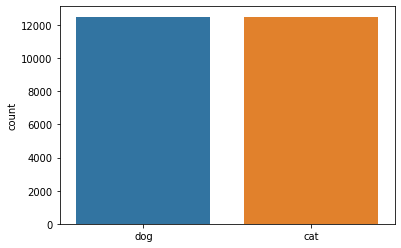

In [6]:
labels = []
for i in os.listdir(TRAIN_DIR):
    if 'dog' in i:
        labels.append('dog')
    else:
        labels.append('cat')

sns.countplot(labels)

In [7]:
df = pd.DataFrame(data = {'img_filepath': os.listdir(TRAIN_DIR), 'label': labels})
df.head(5)

,img_filepath,label
0,dog.8107.jpg,dog
1,cat.8743.jpg,cat
2,dog.1429.jpg,dog
3,cat.2049.jpg,cat
4,cat.7498.jpg,cat


In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [9]:
train_df['label'].value_counts()

cat    10036
dog     9964
Name: label, dtype: int64

In [10]:
val_df['label'].value_counts()

dog    2536
cat    2464
Name: label, dtype: int64

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/data1/train/", 
    x_col='img_filepath',
    y_col='label',
    class_mode='categorical',
    target_size=(128,128),
    batch_size=15
)


Found 20000 validated image filenames belonging to 2 classes.


In [12]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    val_df, 
    "/content/data1/train/", 
    x_col='img_filepath',
    y_col='label',
    class_mode='categorical',
    target_size=(128,128),
    batch_size=15
)

Found 5000 validated image filenames belonging to 2 classes.


In [13]:
test_df = pd.DataFrame(data = {'img_filepath': os.listdir(TEST_DIR)})

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "/content/data1/test/", 
    x_col='img_filepath',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    batch_size=15,
    shuffle=False
)

Found 12500 validated image filenames.


In [15]:
total_train = train_df.shape[0]
total_val = val_df.shape[0]
total_test = test_df.shape[0]

## Modeling

### ResNet

In [16]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [17]:
# Define model
model_resnet = Sequential()
model_resnet.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model_resnet.add(Dense(2, activation='softmax'))
model_resnet.layers[0].trainable = True
model_resnet.compile(
    optimizer='sgd', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
result_resnet = model_resnet.fit_generator(train_generator, validation_data=val_generator,validation_steps=total_val//16,epochs=5)

Epoch 1/5
1334/1334 [==============================] - 276s 201ms/step - loss: 1.3381 - accuracy: 0.6037 - val_loss: 0.9228 - val_accuracy: 0.6628
Epoch 2/5
1334/1334 [==============================] - 244s 183ms/step - loss: 0.5863 - accuracy: 0.7003 - val_loss: 0.4925 - val_accuracy: 0.7694
Epoch 3/5
1334/1334 [==============================] - 244s 183ms/step - loss: 0.4408 - accuracy: 0.7942 - val_loss: 0.3397 - val_accuracy: 0.8489
Epoch 4/5
1334/1334 [==============================] - 243s 182ms/step - loss: 0.3286 - accuracy: 0.8552 - val_loss: 0.2402 - val_accuracy: 0.8951
Epoch 5/5
1334/1334 [==============================] - 242s 182ms/step - loss: 0.2596 - accuracy: 0.8885 - val_loss: 0.1865 - val_accuracy: 0.9220


In [19]:
predict_resnet = model_resnet.predict_generator(test_generator, steps=np.ceil(total_test/15), verbose=1)

834/834 [==============================] - 55s 65ms/step


In [20]:
test_df['label_resnet'] = list(predict_resnet[:,1])

In [21]:
test_df['id'] = test_df['img_filepath'].str.replace('.jpg', '')
test_df['id'] = test_df['id'].astype(int)
test_df.sort_values(by = 'id')
test_df.head()

,img_filepath,label_resnet,id
0,5433.jpg,0.997801,5433
1,1143.jpg,0.003910,1143
2,1478.jpg,0.000106,1478
3,2596.jpg,0.765157,2596
4,4890.jpg,0.997974,4890


In [23]:
test_df[['id', 'label_resnet']].to_csv('submission_res50_4.csv', index = False)

Results on Kaggle: 0.22197

### VGG16

The Keras model of the 16-layer network.

In [24]:
from tensorflow.keras.applications import VGG16

In [25]:
pre_trained_model = VGG16(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)
model_vgg16 = Model(pre_trained_model.input, x)
model_vgg16.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [26]:
result_vgg16 = model_vgg16.fit_generator(train_generator, validation_data=val_generator,validation_steps=total_val//16,epochs=5)

Epoch 1/5
1334/1334 [==============================] - 266s 196ms/step - loss: 0.3127 - accuracy: 0.8619 - val_loss: 0.1176 - val_accuracy: 0.9543
Epoch 2/5
1334/1334 [==============================] - 243s 182ms/step - loss: 0.1434 - accuracy: 0.9448 - val_loss: 0.0902 - val_accuracy: 0.9624
Epoch 3/5
1334/1334 [==============================] - 241s 181ms/step - loss: 0.1178 - accuracy: 0.9556 - val_loss: 0.1360 - val_accuracy: 0.9451
Epoch 4/5
1334/1334 [==============================] - 241s 181ms/step - loss: 0.0978 - accuracy: 0.9621 - val_loss: 0.0799 - val_accuracy: 0.9662
Epoch 5/5
1334/1334 [==============================] - 244s 183ms/step - loss: 0.0845 - accuracy: 0.9657 - val_loss: 0.0824 - val_accuracy: 0.9665


In [27]:
predict_vgg16 = model_vgg16.predict_generator(test_generator, steps=np.ceil(total_test/15), verbose=1)

834/834 [==============================] - 55s 66ms/step


In [29]:
test_df['label_vgg16'] = list(predict_vgg16[:,1])

In [30]:
test_df['id'] = test_df['img_filepath'].str.replace('.jpg', '')
test_df['id'] = test_df['id'].astype(int)
test_df.sort_values(by = 'id')
test_df.head()

,img_filepath,label_resnet,id,label_vgg16
0,5433.jpg,0.997801,5433,1.000000e+00
1,1143.jpg,0.003910,1143,2.068180e-08
2,1478.jpg,0.000106,1478,1.168140e-08
3,2596.jpg,0.765157,2596,1.057590e-02
4,4890.jpg,0.997974,4890,1.000000e+00


In [32]:
test_df[['id', 'label_vgg16']].to_csv('submission_vgg16_4.csv', index = False)

Results on Kaggle: 0.20174

### VGG19

The Keras model of the 19-layer network. 

In [33]:
from tensorflow.keras.applications import VGG19

In [34]:
pre_trained_model = VGG19(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)
model_vgg19 = Model(pre_trained_model.input, x)
model_vgg19.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
model_vgg19.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [35]:
result_vgg19 = model_vgg19.fit_generator(train_generator, validation_data=val_generator,validation_steps=total_val//16,epochs=5)

Epoch 1/5
1334/1334 [==============================] - 288s 215ms/step - loss: 0.2872 - accuracy: 0.8731 - val_loss: 0.1178 - val_accuracy: 0.9536
Epoch 2/5
1334/1334 [==============================] - 281s 211ms/step - loss: 0.1316 - accuracy: 0.9481 - val_loss: 0.0813 - val_accuracy: 0.9650
Epoch 3/5
1334/1334 [==============================] - 281s 210ms/step - loss: 0.1056 - accuracy: 0.9584 - val_loss: 0.0724 - val_accuracy: 0.9709
Epoch 4/5
1334/1334 [==============================] - 281s 211ms/step - loss: 0.0927 - accuracy: 0.9631 - val_loss: 0.0641 - val_accuracy: 0.9737
Epoch 5/5
1334/1334 [==============================] - 280s 210ms/step - loss: 0.0798 - accuracy: 0.9700 - val_loss: 0.0680 - val_accuracy: 0.9707


In [36]:
predict_vgg19 = model_vgg19.predict_generator(test_generator, steps=np.ceil(total_test/15), verbose=1)

834/834 [==============================] - 60s 72ms/step


In [37]:
test_df['label_vgg19'] = list(predict_vgg19[:,1])

In [38]:
test_df['id'] = test_df['img_filepath'].str.replace('.jpg', '')
test_df['id'] = test_df['id'].astype(int)
test_df.sort_values(by = 'id')
test_df.head()

,img_filepath,label_resnet,id,label_vgg16,label_vgg19
0,5433.jpg,0.997801,5433,1.000000e+00,1.000000e+00
1,1143.jpg,0.003910,1143,2.068180e-08,2.585562e-09
2,1478.jpg,0.000106,1478,1.168140e-08,1.761808e-09
3,2596.jpg,0.765157,2596,1.057590e-02,1.732088e-01
4,4890.jpg,0.997974,4890,1.000000e+00,1.000000e+00


In [39]:
test_df[['id', 'label_vgg19']].to_csv('submission_vgg19_4.csv', index = False)

Results on Kaggle: 0.20409

### Stacking

In [45]:
vgg16=pd.read_csv("submission_vgg16_4.csv",index_col=[0])
vgg19=pd.read_csv("submission_vgg19_4.csv",index_col=[0])
res50=pd.read_csv("submission_res50_4.csv",index_col=[0])


In [46]:
final=pd.concat([vgg16,vgg19,res50],axis=1,join='inner')

In [47]:
final['mean'] = final.mean(axis=1)
final.head()

,label_vgg16,label_vgg19,label_resnet,mean
id,,,,
5433,1.000000e+00,1.000000e+00,0.997802,0.999267
1143,2.068180e-08,2.585562e-09,0.003910,0.001303
1478,1.168140e-08,1.761808e-09,0.000106,0.000035
2596,1.057590e-02,1.732088e-01,0.765157,0.316314
4890,1.000000e+00,1.000000e+00,0.997974,0.999325


In [48]:
final=final['mean']
final=final.reset_index()
final.columns=['id','label']
final.head()

,id,label
0,5433,0.999267
1,1143,0.001303
2,1478,0.000035
3,2596,0.316314
4,4890,0.999325


In [49]:
final.to_csv("submission_stacking_1.csv",index=False)

Results on Kaggle: 0.12464

## Final Prediction 

The best performance is using stacking among all three models. 

In [52]:
test_dfs=pd.concat([test_df,final],axis=1,join='inner')

In [54]:
pic = test_dfs.iloc[200:250,:]
pic.reset_index(inplace=True)
pic.loc[pic['label']>=0.5,'category'] = 'Dog'
pic.loc[pic['label']<0.5,'category'] = 'Cat'
pic = pic.head(10)

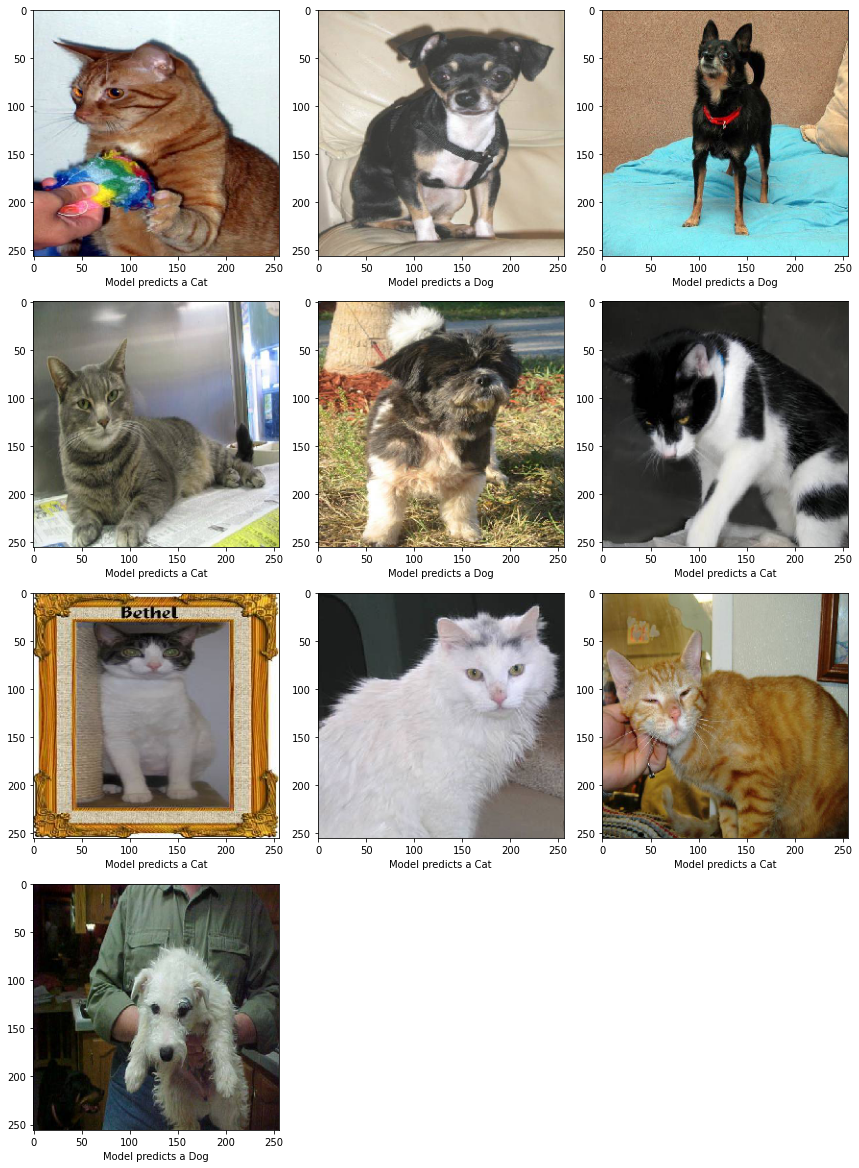

In [55]:
plt.figure(figsize=(12, 24))
for index, row in pic.iterrows():
    filename = row['img_filepath']
    category = row['category']
    img = load_img("/content/data1/test/"+filename, target_size=(256,256))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel('Model predicts a ' + "{}".format(category))
plt.tight_layout()
plt.show()